# Importing Libraries

In [1]:
#Basic Libraries
import pandas as pd
import matplotlib.pyplot as plt

#Text Processing Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer

#Ml Model Library
from sklearn.naive_bayes import MultinomialNB

#Evaluation Libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import itertools

#warnings
import warnings
warnings.filterwarnings('ignore')

# Reading the data into pandas

In [2]:
df = pd.read_csv('SMSSpamCollection',sep = "\t",header = None)
df.set_axis(["target", "text"], axis=1, inplace=True)
df

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# Exploratory Data Analysis

In [3]:
df.describe()

,target,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
df.groupby('target').describe()

text                                                               
       count unique                                                top freq
target                                                                     
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

We have 4825 ham messages and 747 spam messages

# Feature Engineering

In [5]:
# convert label to a numerical variable
df['target_num'] = df.target.map({'ham':0, 'spam':1})
df.head()

,target,text,target_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [6]:
df['text_len'] = df.text.apply(len)
df.head()

,target,text,target_num,text_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Text Length')

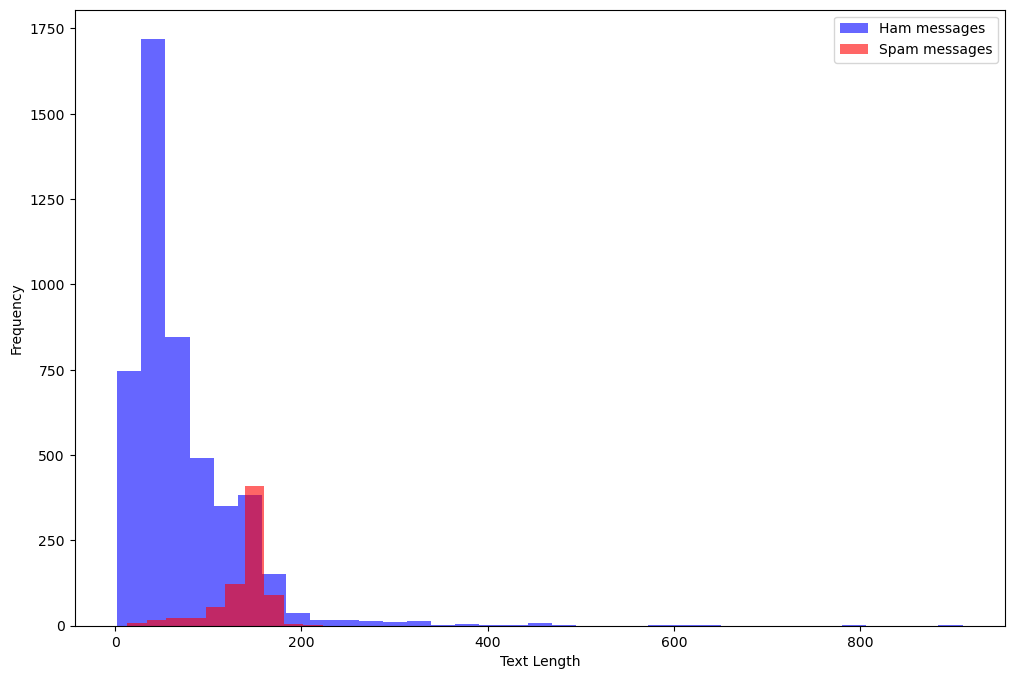

In [7]:
plt.figure(figsize=(12, 8))

df[df.target=='ham'].text_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
df[df.target=='spam'].text_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Text Length")

In [8]:
df[df.target=='ham'].describe()

,target_num,text_len
count,4825.0,4825.000000
mean,0.0,71.482487
std,0.0,58.440652
min,0.0,2.000000
25%,0.0,33.000000
50%,0.0,52.000000
75%,0.0,93.000000
max,0.0,910.000000


In [9]:
df[df.target=='spam'].describe()

,target_num,text_len
count,747.0,747.000000
mean,1.0,138.670683
std,0.0,28.873603
min,1.0,13.000000
25%,1.0,133.000000
50%,1.0,149.000000
75%,1.0,157.000000
max,1.0,223.000000


# Text Pre-processing

In [10]:
#Create a function to process the text
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [11]:
df['clean_text'] = df.text.apply(text_process)

df.head()

,target,text,target_num,text_len,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though


In [12]:
#Get the frequency of ham words
words = df[df.target=='ham'].clean_text.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))

[('get', 303), ('ltgt', 276), ('ok', 273), ('go', 250), ('ill', 238), ('got', 232), ('know', 232), ('like', 231), ('call', 231), ('come', 227), ('good', 224), ('love', 190), ('time', 189), ('day', 188), ('going', 167), ('want', 164), ('one', 163), ('home', 160), ('lor', 160), ('need', 157), ('sorry', 153), ('still', 147), ('see', 138), ('n', 137), ('later', 134), ('da', 131), ('r', 131), ('back', 129), ('think', 128), ('well', 127), ('today', 125), ('send', 123), ('tell', 121), ('cant', 119), ('hi', 117), ('take', 112), ('oh', 112), ('much', 112), ('night', 109), ('happy', 106), ('hey', 106), ('great', 100), ('way', 100), ('hope', 100), ('pls', 98), ('work', 97), ('wat', 95), ('thats', 95), ('give', 94), ('dear', 94)]


In [13]:
#Get the frequency of spam words
words = df[df.target=='spam'].clean_text.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(50))

[('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('stop', 115), ('claim', 113), ('reply', 101), ('prize', 92), ('get', 83), ('new', 69), ('send', 68), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60), ('contact', 56), ('service', 55), ('please', 52), ('16', 51), ('guaranteed', 50), ('customer', 49), ('week', 49), ('tone', 48), ('per', 46), ('phone', 45), ('18', 43), ('chat', 42), ('awarded', 38), ('draw', 38), ('latest', 36), ('£1000', 35), ('line', 35), ('150ppm', 34), ('mins', 34), ('receive', 33), ('camera', 33), ('1', 33), ('box', 33), ('every', 33), ('message', 32), ('po', 32), ('holiday', 32), ('landline', 32), ('shows', 31), ('£2000', 31), ('go', 31), ('number', 30), ('apply', 29), ('code', 29)]


# Vectorization

In [14]:
## Get the Independent Features

X=df.clean_text
y=df.target_num

In [15]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [16]:
## TFidf Vectorizer
tfidf_v=TfidfVectorizer(max_features=1000,ngram_range=(1,3))
X_train=tfidf_v.fit_transform(X_train)
X_test = tfidf_v.transform(X_test)

In [17]:
## TFidf Transformer
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train)
tfidf_transformer.transform(X_train)

<3733x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 21483 stored elements in Compressed Sparse Row format>

# Building and Evaluating the Model

In [18]:
classifier=MultinomialNB()

In [19]:
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
score

0.9793365959760739

In [20]:
y_train.shape

(3733,)

In [21]:
classifier=MultinomialNB(alpha=0.1)

# Hyper-Parameter Tuning

In [22]:
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train,y_train)
    y_pred=sub_classifier.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

Alpha: 0.0, Score : 0.9798803697661773
Alpha: 0.1, Score : 0.9815116911364872
Alpha: 0.2, Score : 0.9820554649265906
Alpha: 0.30000000000000004, Score : 0.9809679173463839
Alpha: 0.4, Score : 0.9809679173463839
Alpha: 0.5, Score : 0.9804241435562806
Alpha: 0.6000000000000001, Score : 0.9798803697661773
Alpha: 0.7000000000000001, Score : 0.9793365959760739
Alpha: 0.8, Score : 0.9793365959760739
Alpha: 0.9, Score : 0.9793365959760739


In [23]:
## Get Features names
feature_names = tfidf_v.get_feature_names_out()

In [24]:
### Most Spam words
sorted(zip(classifier.coef_[0], feature_names), reverse=True)[:20]

[(-4.203549439372702, 'call'),
 (-4.467868586088068, 'free'),
 (-4.706028237449997, 'txt'),
 (-4.739975860568375, 'stop'),
 (-4.845226388034087, 'text'),
 (-4.885389160666788, 'claim'),
 (-4.957468945606582, 'reply'),
 (-4.974476910257605, 'mobile'),
 (-5.023540104929191, 'prize'),
 (-5.191617993438054, 'new'),
 (-5.28583720824757, 'win'),
 (-5.3236453077216765, 'service'),
 (-5.3600806101601375, 'urgent'),
 (-5.363324571295498, 'send'),
 (-5.384554740002897, 'cash'),
 (-5.394879194425959, 'get'),
 (-5.495122417509863, 'please'),
 (-5.497169786456823, 'please call'),
 (-5.509779487200047, 'nokia'),
 (-5.533918096991947, 'contact')]

In [25]:
### Most ham words
sorted(zip(classifier.coef_[0], feature_names))[:50]

[(-7.9205165782827045, 'able'),
 (-7.9205165782827045, 'abt'),
 (-7.9205165782827045, 'actually'),
 (-7.9205165782827045, 'aft'),
 (-7.9205165782827045, 'afternoon'),
 (-7.9205165782827045, 'ago'),
 (-7.9205165782827045, 'ah'),
 (-7.9205165782827045, 'aight'),
 (-7.9205165782827045, 'aint'),
 (-7.9205165782827045, 'almost'),
 (-7.9205165782827045, 'alright'),
 (-7.9205165782827045, 'always'),
 (-7.9205165782827045, 'amp'),
 (-7.9205165782827045, 'angry'),
 (-7.9205165782827045, 'anything'),
 (-7.9205165782827045, 'anyway'),
 (-7.9205165782827045, 'ard'),
 (-7.9205165782827045, 'around'),
 (-7.9205165782827045, 'ask'),
 (-7.9205165782827045, 'askd'),
 (-7.9205165782827045, 'asking'),
 (-7.9205165782827045, 'ass'),
 (-7.9205165782827045, 'awesome'),
 (-7.9205165782827045, 'bak'),
 (-7.9205165782827045, 'bank'),
 (-7.9205165782827045, 'bath'),
 (-7.9205165782827045, 'bathe'),
 (-7.9205165782827045, 'bb'),
 (-7.9205165782827045, 'bcoz'),
 (-7.9205165782827045, 'bday'),
 (-7.920516578282704